# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )


In [1]:
!cp -R /kaggle/input/tmp-auto/AutoML-main /kaggle/working/AutoML-main

In [2]:
!pip install /kaggle/working/AutoML-main

Processing ./AutoML-main
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sme-utils: filename=sme_utils-0.2.0-py3-none-any.whl size=51501 sha256=b6813a0ed037665969de5caa572725bde4ca3931fabbca9b050d6c3b75b41bc2
  Stored in directory: /root/.cache/pip/wheels/f5/a3/0c/cce8196426f85ae65fc8a012518ccef81c2be285fbb3d2f78b
Successfully built sme-utils


In [3]:
from sme_utils.encoding_and_transforms import WOENumericalComplex 

# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [4]:
# !pip list

In [5]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

# new
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [6]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [7]:
dataset_df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [8]:
# dataset_df.describe()

## Pie chart for label column: Class

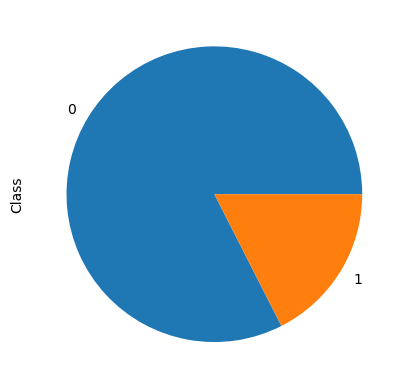

In [9]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")
plt.show()

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [10]:
dataset_df.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [11]:
dataset_df[['EJ','DU','EH','FD','FL','GL']].value_counts()

EJ  DU          EH         FD           FL          GL       
A   0.005518    0.003042   0.296850     0.173229    21.978000    222
B   0.006897    0.024336   0.296850     0.296625    2.376000       4
    0.055176    0.012168   1.139904     6.443383    0.148500       3
    0.006897    0.006084   1.027101     4.105290    0.594000       2
    1.338018    0.091260   1.502061     5.574782    0.045928       1
                                                                ... 
    0.482790    0.006084   1.763289     58.966209   0.008486       1
    0.462099    0.097344   2.119509     4.333945    0.141851       1
    0.448305    0.152100   2.172942     2.800886    0.228462       1
                0.127764   3.004122     4.609838    0.191908       1
    161.355315  42.569748  1578.654237  137.932739  0.177654       1
Length: 389, dtype: int64

Now let us split the dataset into training and testing datasets:

# Feature Engineering

## Filter Monotonic Features

In [12]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

basic_stats_1

  0%|          | 0/56 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


In [13]:
basic_stats_1.query('na_share > 0').index

Index(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], dtype='object')

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


## Normalise Features

In [14]:
def preprocess_1(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    stats_features = stats[stats.logloss.notna()].index
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in stats_features:
        if i != 'EJ':
            tmp_woe = WOENumericalComplex()
            tmp_woe.fit(x=train_out[i], y=train_out['Class'])
            train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
            test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
            out_features.append(i + '_WoE')
    
    
    # Make NA columns
    for i in ['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ']:
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in stats_features:
        if i != 'EJ':

            if stats.loc[i,'correlation'] > 0:
                na_value = stats.loc[i,'max']
            else:
                na_value = stats.loc[i,'min']
                
            train_out[i] = train_out[i].fillna(na_value)
            test_out[i] = test_out[i].fillna(na_value)
            
            train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
            test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
            
            out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out[i + '_A'] = np.where(train_out[i] == 'A',1,0)
    test_out[i + '_A'] = np.where(test_out[i] == 'A',1,0)
    out_features.append(i + '_A')
    
    return train_out,test_out,out_features


train_out_1,test_out_1,out_features_1 = preprocess_1(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

/tmp/ipykernel_20/393966730.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_out[i + '_A'] = np.where(train_out[i] == 'A',1,0)
/tmp/ipykernel_20/393966730.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_out[i + '_A'] = np.where(test_out[i] == 'A',1,0)


In [15]:
out_features_1

['DU_WoE',
 'BC_WoE',
 'AF_WoE',
 'EH_WoE',
 'AM_WoE',
 'FD_WoE',
 'DI_WoE',
 'FR_WoE',
 'AB_WoE',
 'CF_WoE',
 'BZ_WoE',
 'FE_WoE',
 'AX_WoE',
 'BR_WoE',
 'GB_WoE',
 'AY_WoE',
 'FC_WoE',
 'FS_WoE',
 'CC_WoE',
 'GH_WoE',
 'DV_WoE',
 'DY_WoE',
 'EE_WoE',
 'GE_WoE',
 'AH_WoE',
 'DN_WoE',
 'EP_WoE',
 'EU_WoE',
 'EG_WoE',
 'FI_WoE',
 'DH_WoE',
 'GF_WoE',
 'GI_WoE',
 'DE_WoE',
 'DA_WoE',
 'CW_WoE',
 'CU_WoE',
 'AZ_WoE',
 'CL_WoE',
 'CH_WoE',
 'BD_WoE',
 'BN_WoE',
 'DL_WoE',
 'CS_WoE',
 'FL_WoE',
 'GL_WoE',
 'CB_WoE',
 'DF_WoE',
 'BP_WoE',
 'EB_WoE',
 'AR_WoE',
 'CD_WoE',
 'EL_WoE',
 'CR_WoE',
 'BQ_WoE',
 'DU_na',
 'FC_na',
 'FS_na',
 'CC_na',
 'FL_na',
 'GL_na',
 'CB_na',
 'EL_na',
 'BQ_na',
 'DU',
 'BC',
 'AF',
 'EH',
 'AM',
 'FD',
 'DI',
 'FR',
 'AB',
 'CF',
 'BZ',
 'FE',
 'AX',
 'BR',
 'GB',
 'AY',
 'FC',
 'FS',
 'CC',
 'GH',
 'DV',
 'DY',
 'EE',
 'GE',
 'AH',
 'DN',
 'EP',
 'EU',
 'EG',
 'FI',
 'DH',
 'GF',
 'GI',
 'DE',
 'DA',
 'CW',
 'CU',
 'AZ',
 'CL',
 'CH',
 'BD',
 'BN',
 'DL',
 'CS

# KFold validation

We will use KFold cross validation for training this model since the normal train/test split training won't be enough to acheive decent score.

We will split the dataset into 5 consecutive folds. Each fold is then used once as a validation set while the 4 (5-1) remaining folds form the training set.

Read more about KFold [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [16]:
# skf = StratifiedKFold(n_splits=8)
# X,y = dataset_df_normalised.values.copy(),dataset_df['Class'].values.reshape(-1,1).copy()
# for train, test in skf.split(X=X, y=y):
#     print(f'train -  {y[train].sum()/len(y[train])}   |   test -  {y[train].sum()/len(y[train])}')

# Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named `oof` to store the predictions of the validation set during each fold.

In [17]:
# # Added to train step
# # Create list of ids for the creation of oof dataframe.
# ID_LIST = dataset_df.index

# # Create a dataframe of required size with zero values.
# oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# # Create an empty dictionary to store the models trained for each fold.
# models = {}

# # Create empty dict to save metircs for the models trained for each fold.
# accuracy = {}
# cross_entropy = {}

# # Save the name of the label column to a variable.
# label = "Class"

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [18]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get a better score.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Hyperparameter tuning to avoid overfitting

Because of the smaller size of the dataset, it is likely that the model will overfit during training.
Numerous parameters, primarily `max_depth` and `num_trees` can be changed to fine-tune the model and prevent overfitting.

The attribute`max_depth` indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is `16`. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter `num_trees` from its default value(`300`).

You can set these parameters as follows:

```rf = tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)```

# Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's  by examining the`Class` column.

In [19]:
# # Calculate the number of negative and positive values in `Class` column
# neg, pos = np.bincount(dataset_df['Class'])
# # Calculate total samples
# total = neg + pos
# print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

# Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

```
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)
```

# Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **Keras weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [20]:
# # Added to Train Step
# # Calculate the number of samples for each label.
# neg, pos = np.bincount(dataset_df['Class'])

# # Calculate total samples.
# total = neg + pos

# # Calculate the weight for each label.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```model.fit(x=train_ds, class_weight=class_weight)```

# Train Random Forest Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [21]:
def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, dict):

    # Create a dataframe of required size with zero values.
    oof = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}

    # Create empty dict to save metircs for the models trained for each fold.
    accuracy = {}
    cross_entropy = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in oof dataframe
            oof.loc[valid_ids, 0] = model.predict(x=valid_ds).flatten()
            submition.loc[:, i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
            cross_entropy[f"fold_{i+1}"] = evaluation["binary_crossentropy"]
            
    return submition,models,accuracy,cross_entropy


def print_average_accuracy(models,cross_entropy,accuracy):
    average_loss = 0
    average_acc = 0

    for _model in  models:
        average_loss += cross_entropy[_model]
        average_acc += accuracy[_model]
        print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

    print(f"\nAverage accuracy: {average_acc/len(models):.4f}  Average loss: {average_loss/len(models):.4f}")

In [22]:
# RandomForestModel
submition_1, model_1,accuracy_1,cross_entropy_1 = train_model(train=train_out_1,test=test_out_1, features=out_features_1,
                                                              n_splits=10, 
                                                              model_obj=tfdf.keras.RandomForestModel,
                                                              model_kwargs=dict(max_depth=6, num_trees=1000),
                                                              model_compile_kwargs=dict(metrics=["accuracy", "binary_crossentropy"]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpat2jc4mg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.892495. Found 555 examples.
Training model...
Model trained in 0:00:00.834630
Compiling model...


[INFO 23-07-09 21:26:04.4997 UTC kernel.cc:1242] Loading model from path /tmp/tmpat2jc4mg/model/ with prefix 12e5208245734da4
[INFO 23-07-09 21:26:04.6437 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34340 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:04.6440 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-09 21:26:04.6442 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 964ms/step - loss: 0.0000e+00 - accuracy: 0.9677 - binary_crossentropy: 0.2042
##### Fold 2
Use /tmp/tmptufsg5v9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.403067. Found 555 examples.
Training model...
Model trained in 0:00:00.757111
Compiling model...


[INFO 23-07-09 21:26:13.7901 UTC kernel.cc:1242] Loading model from path /tmp/tmptufsg5v9/model/ with prefix 8a407f361af441eb
[INFO 23-07-09 21:26:13.9253 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34608 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:13.9254 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 576ms/step - loss: 0.0000e+00 - accuracy: 0.9355 - binary_crossentropy: 0.2154
##### Fold 3
Use /tmp/tmpbhk3thes as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.295778. Found 555 examples.
Training model...
Model trained in 0:00:00.757419
Compiling model...


[INFO 23-07-09 21:26:20.8860 UTC kernel.cc:1242] Loading model from path /tmp/tmpbhk3thes/model/ with prefix 5789e1636fff4333
[INFO 23-07-09 21:26:21.0351 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34544 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:21.0351 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-09 21:26:21.0352 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 679ms/step - loss: 0.0000e+00 - accuracy: 0.8548 - binary_crossentropy: 0.2748
##### Fold 4
Use /tmp/tmpea3y3g7f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.575737. Found 555 examples.
Training model...
Model trained in 0:00:00.781117
Compiling model...


[INFO 23-07-09 21:26:28.1258 UTC kernel.cc:1242] Loading model from path /tmp/tmpea3y3g7f/model/ with prefix 1dc1dfedf8264c0a
[INFO 23-07-09 21:26:28.2666 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34348 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:28.2667 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 633ms/step - loss: 0.0000e+00 - accuracy: 0.8710 - binary_crossentropy: 0.2786
##### Fold 5
Use /tmp/tmp6rik58ss as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.508620. Found 555 examples.
Training model...
Model trained in 0:00:00.869159
Compiling model...


[INFO 23-07-09 21:26:35.2908 UTC kernel.cc:1242] Loading model from path /tmp/tmp6rik58ss/model/ with prefix 99d4335ec3d94ffc
[INFO 23-07-09 21:26:35.4442 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34704 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:35.4443 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-09 21:26:35.4443 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 613ms/step - loss: 0.0000e+00 - accuracy: 0.9355 - binary_crossentropy: 0.2320
##### Fold 6
Use /tmp/tmpia1xsx82 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.395886. Found 555 examples.
Training model...
Model trained in 0:00:00.815260
Compiling model...


[INFO 23-07-09 21:26:42.2856 UTC kernel.cc:1242] Loading model from path /tmp/tmpia1xsx82/model/ with prefix 6f5f7b358393490b
[INFO 23-07-09 21:26:42.4265 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34388 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:42.4266 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 2s 2s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 592ms/step - loss: 0.0000e+00 - accuracy: 0.9194 - binary_crossentropy: 0.2703
##### Fold 7
Use /tmp/tmpzl7rwy81 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.350356. Found 555 examples.
Training model...
Model trained in 0:00:00.799512
Compiling model...


[INFO 23-07-09 21:26:49.5782 UTC kernel.cc:1242] Loading model from path /tmp/tmpzl7rwy81/model/ with prefix b6890dc6e3454b26
[INFO 23-07-09 21:26:49.7254 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34538 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:49.7255 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-09 21:26:49.7256 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 607ms/step - loss: 0.0000e+00 - accuracy: 0.9194 - binary_crossentropy: 0.2685
##### Fold 8
Use /tmp/tmp8j4onp3g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.378273. Found 556 examples.
Training model...
Model trained in 0:00:01.042518
Compiling model...


[INFO 23-07-09 21:26:57.2669 UTC kernel.cc:1242] Loading model from path /tmp/tmp8j4onp3g/model/ with prefix c7d1bf83199f4912
[INFO 23-07-09 21:26:57.4250 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34352 node(s), and 112 input feature(s).
[INFO 23-07-09 21:26:57.4254 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 656ms/step - loss: 0.0000e+00 - accuracy: 0.9344 - binary_crossentropy: 0.2563
##### Fold 9
Use /tmp/tmphgttfoo7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.283885. Found 556 examples.
Training model...
Model trained in 0:00:00.811234
Compiling model...


[INFO 23-07-09 21:27:04.3262 UTC kernel.cc:1242] Loading model from path /tmp/tmphgttfoo7/model/ with prefix cd6ee1da72d44804
[INFO 23-07-09 21:27:04.4835 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34134 node(s), and 112 input feature(s).
[INFO 23-07-09 21:27:04.4836 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-09 21:27:04.4836 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 650ms/step - loss: 0.0000e+00 - accuracy: 0.9180 - binary_crossentropy: 0.2567
##### Fold 10
Use /tmp/tmppx9bt3pu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.251472. Found 556 examples.
Training model...
Model trained in 0:00:00.790948
Compiling model...


[INFO 23-07-09 21:27:11.2021 UTC kernel.cc:1242] Loading model from path /tmp/tmppx9bt3pu/model/ with prefix eb03256a54704e4a
[INFO 23-07-09 21:27:11.3547 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34658 node(s), and 112 input feature(s).
[INFO 23-07-09 21:27:11.3550 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 987ms/step


/tmp/ipykernel_20/2061138087.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submition.loc[:, i] = model.predict(x=submition_ds).flatten()


1/1 [==============================] - 1s 632ms/step - loss: 0.0000e+00 - accuracy: 0.9672 - binary_crossentropy: 0.2142


In [23]:
print('Type 1')
print_average_accuracy(models=model_1, cross_entropy=cross_entropy_1, accuracy=accuracy_1)

Type 1
fold_1: acc: 0.9677 loss: 0.2042
fold_2: acc: 0.9355 loss: 0.2154
fold_3: acc: 0.8548 loss: 0.2748
fold_4: acc: 0.8710 loss: 0.2786
fold_5: acc: 0.9355 loss: 0.2320
fold_6: acc: 0.9194 loss: 0.2703
fold_7: acc: 0.9194 loss: 0.2685
fold_8: acc: 0.9344 loss: 0.2563
fold_9: acc: 0.9180 loss: 0.2567
fold_10: acc: 0.9672 loss: 0.2142

Average accuracy: 0.9223  Average loss: 0.2471


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select any tree for display.

Let us pick one model from the `models` dict and select a tree for display.

In [24]:
# tfdf.model_plotter.plot_model_in_colab(model_2['fold_1'], tree_idx=20, max_depth=10)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training, we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model. The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the `binary_crossentropy` evaluated on the out of bag dataset according to the number of trees in the model. Let us plot this for the models of each fold.

Note: Smaller values are better for this hyperparameter.

In [25]:
# figure, axis = plt.subplots(3, 2, figsize=(10, 10))
# plt.subplots_adjust(hspace=0.5, wspace=0.3)

# for i, fold_no in enumerate(model_2.keys()):
#     row = i//2
#     col = i % 2
#     logs = model_1[fold_no].make_inspector().training_logs()
#     axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
#     axis[row, col].set_title(f"Fold {i+1}")
#     axis[row, col].set_xlabel('Number of trees')
#     axis[row, col].set_ylabel('Loss (out-of-bag)')

# # axis[2][1].set_visible(False)
# plt.show()

We can also see some general stats on the OOB dataset:

In [26]:
# for _model in model_1:
#     inspector = model_1[_model].make_inspector()
#     print(_model, inspector.evaluation())

# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available `Variable Importances` for Decision Trees:

In [27]:
# inspector = model_1['fold_1'].make_inspector()

# print(f"Available variable importances:")
# for importance in inspector.variable_importances().keys():
#     print("\t", importance)

As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [28]:
# Each line is: (feature name, (index of the feature), importance score)
# inspector.variable_importances()["NUM_AS_ROOT"]

# Submission

In [29]:
def create_submitions(submition: pd.DataFrame) -> pd.DataFrame:
    
    df = pd.DataFrame(data=np.zeros((len(submition.index),2)),index=submition.index, columns=['class_0','class_1'])
    
    df['class_1'] = submition_1.mean(axis=1)
    df['class_0'] = 1 - df['class_1']
    
    return df

In [30]:
submition_1_final = create_submitions(submition=submition_1)

In [31]:
submition_1_final

,class_0,class_1
Id,,
00eed32682bb,0.653601,0.346399
010ebe33f668,0.653601,0.346399
02fa521e1838,0.653601,0.346399
040e15f562a2,0.653601,0.346399
046e85c7cc7f,0.653601,0.346399


In [32]:
submition_1_final.to_csv('/kaggle/working/submission.csv', index=True)